# Airbnb Hotel Booking Analysis

**Abstract:** This project analyzes Airbnb listings to understand pricing drivers, booking patterns, and listing quality. It delivers actionable insights for hosts to optimize pricing and availability, and for travelers to identify value listings.

**Goals:**
- **Pricing drivers:** Identify which features most influence price and bookings.
- **Market overview:** Understand distribution across neighborhoods and room types.
- **Operational insights:** Detect data quality issues and patterns in availability and reviews.
- **Recommendations:** Provide data backed guidance for hosts and travelers.
- **Conclusions:** Provide ultimate verdict from this analysis.

In [2]:
# 1.1. Install libraries
!pip -q install pandas numpy seaborn matplotlib plotly folium openpyxl

# 1.2. Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import folium

# 1.3. Settings
pd.set_option('display.max_columns', 100)
sns.set_theme(style="whitegrid", context="notebook")
RANDOM_STATE = 42

# 2.1. Load data (path name)
path = "/content/Airbnb_Open_Data.xlsx"
df = pd.read_excel(path)

# 2.2. Quick peek
df.head(), df.shape, df.dtypes

(        id                                              NAME      host id  \
 0  1001254                Clean & quiet apt home by the park  80014485718   
 1  1002102                             Skylit Midtown Castle  52335172823   
 2  1002403               THE VILLAGE OF HARLEM....NEW YORK !  78829239556   
 3  1002755                                               NaN  85098326012   
 4  1003689  Entire Apt: Spacious Studio/Loft by central park  92037596077   
 
   host_identity_verified host name neighbourhood group neighbourhood  \
 0            unconfirmed  Madaline            Brooklyn    Kensington   
 1               verified     Jenna           Manhattan       Midtown   
 2                    NaN     Elise           Manhattan        Harlem   
 3            unconfirmed     Garry            Brooklyn  Clinton Hill   
 4               verified    Lyndon           Manhattan   East Harlem   
 
         lat      long        country country code  instant_bookable  \
 0  40.64749 -73.9

### Data dictionary

- **Key identifiers:** id, host_id, host_identity_verified
- **Pricing & policy:** price, minimum_nights, service_fee
- **Location:** neighbourhood, lat, long
- **Property:** room_type, accommodates, cancellation_olicy, instant_bookable
- **Demand signals:** number_of_reviews, reviews_per_month, last_review, availability_365
- **Quality:** review_scores_rating, host_rules, Construction_year



In [3]:
# 3.1. Missingness overview
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().mean()*100).sort_values(ascending=False)
display(pd.DataFrame({"missing": missing, "missing_%": missing_pct}).head(20))

# Handle datatypes
if 'last_review' in df.columns:
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

# 3.2. Convert price-like fields to numeric by stripping symbols
for col in ['price', 'cleaning_fee', 'security_deposit']:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = (df[col].astype(str)
                   .str.replace('[^0-9.]', '', regex=True)
                   .replace('', np.nan)
                   .astype(float))

# Drop duplicates (based on listing_id if available)
if 'listing_id' in df.columns:
    df = df.drop_duplicates(subset=['listing_id'])
else:
    df = df.drop_duplicates()

# 3.3. Imputation strategy
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Numeric: median; categorical: mode
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0] if len(df[col].mode()) else 'Unknown')

# 3.4. Outlier handling: price and minimum_nights
if 'price' in df.columns:
    q_low, q_hi = df['price'].quantile([0.01, 0.99])
    df = df[(df['price'] >= q_low) & (df['price'] <= q_hi)]

if 'minimum_nights' in df.columns:
    df['minimum_nights'] = np.clip(df['minimum_nights'], 1, 30)

# 3.5. Standardize categorical labels
for col in ['neighbourhood', 'room_type']:
    if col in df.columns:
        df[col] = df[col].str.strip().str.title()

df.shape

,missing,missing_%
license,102597,99.998051
house_rules,54843,53.453737
last review,15893,15.490404
reviews per month,15879,15.476759
country,532,0.518524
availability 365,448,0.436651
minimum nights,409,0.398639
host name,408,0.397665
review rate number,326,0.317742
calculated host listings count,319,0.310919


(100094, 26)

**Cleaning decisions:**
- **Imputation:** Numeric medians to preserve distributions; categorical modes to maintain common labels.
- **Outliers:** Trimmed extreme 1% tails for price to reduce skew.
- **Types:** Currency fields cast to float; dates parsed; categorical labels standardized.



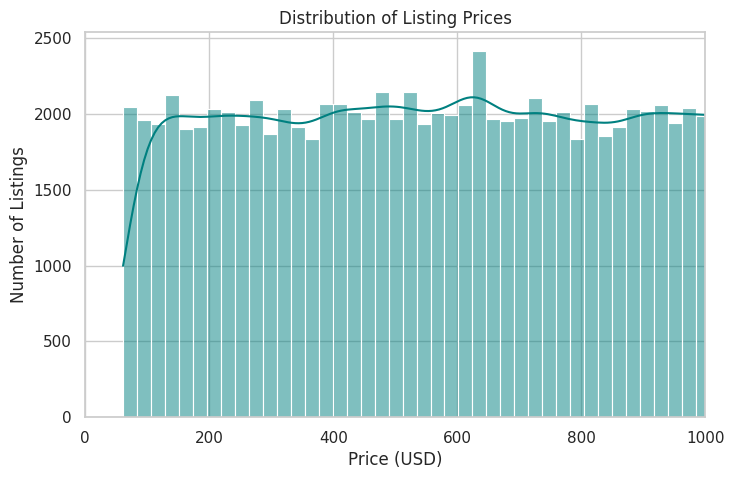

/tmp/ipython-input-3797091115.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='room type', y='price', palette='Set2')


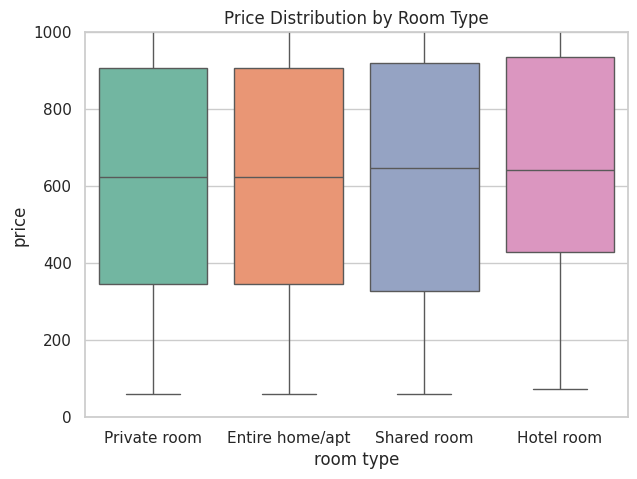

/tmp/ipython-input-3797091115.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='neighbourhood group', y='price', palette='muted')


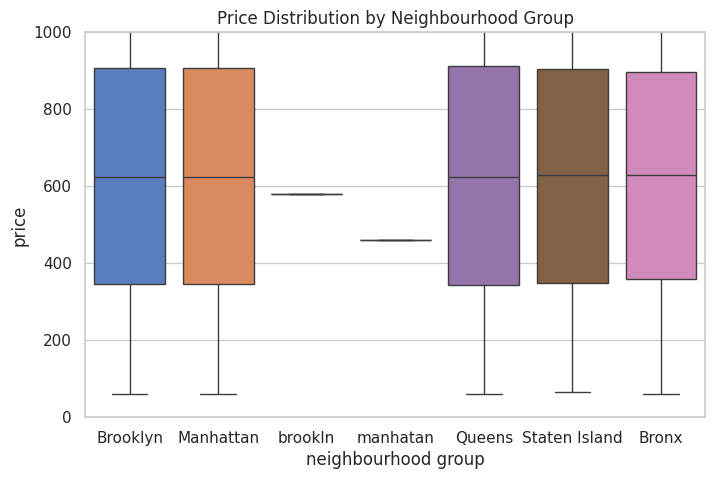

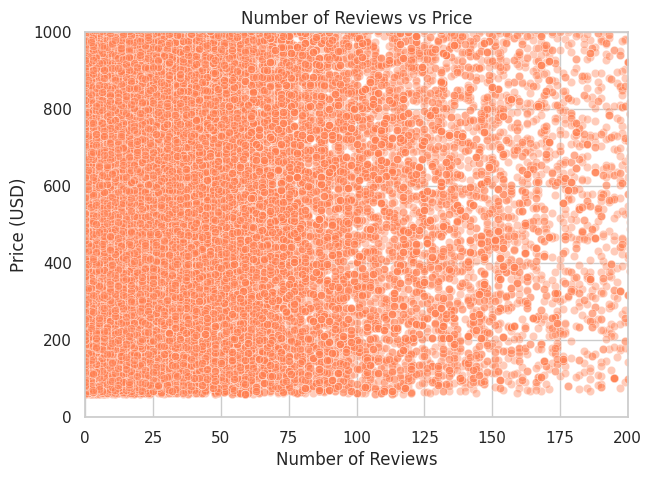

In [4]:
# 4.1. Price Distribution
plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=50, kde=True, color='teal')
plt.xlim(0, 1000)  # cap extreme outliers for readability
plt.title("Distribution of Listing Prices")
plt.xlabel("Price (USD)")
plt.ylabel("Number of Listings")
plt.show()

# 4.2. Room Type vs Price
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x='room type', y='price', palette='Set2')
plt.ylim(0, 1000)
plt.title("Price Distribution by Room Type")
plt.show()

# 4.3. Neighbourhood Group vs Price
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='neighbourhood group', y='price', palette='muted')
plt.ylim(0, 1000)
plt.title("Price Distribution by Neighbourhood Group")
plt.show()

# 4.4. Geospatial Map of Listings
m = folium.Map(location=[df['lat'].median(), df['long'].median()], zoom_start=11)
sample = df.sample(min(1000, len(df)))  # sample for performance
for _, row in sample.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=2,
        fill=True,
        fill_color='red' if row['price'] > df['price'].median() else 'blue',
        fill_opacity=0.5
    ).add_to(m)
display(m)  # shows interactive map in Colab

# 4.5. Number of Reviews vs Price
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='number of reviews', y='price', alpha=0.4, color='coral')
plt.xlim(0, 200)
plt.ylim(0, 1000)
plt.title("Number of Reviews vs Price")
plt.xlabel("Number of Reviews")
plt.ylabel("Price (USD)")
plt.show()

**EDA highlights:**
1. **Price distribution:** Market is skewed toward budget listings, with a long luxury tail.  
2. **Room type segmentation:** Entire homes command the highest prices; shared rooms are cheapest.  
3. **Neighborhood premiums:** Certain groups/neighborhoods consistently price higher.  
4. **Geospatial clusters:** Premium listings cluster in central/tourist hubs; budget options spread outward.  
5. **Demand vs price:** Cheaper listings tend to accumulate more reviews, suggesting higher booking frequency.  

In [5]:
# 5.1. Price per person (value normalization)
if {'price','room type'}.issubset(df.columns) and 'minimum nights' in df.columns:
    if 'accommodates' in df.columns:
        df['price_per_person'] = df['price'] / np.maximum(df['accommodates'], 1)
    else:
        # fallback: approximate using room type
        df['price_per_person'] = df['price'] / (
            df['room type'].map({'Entire home/apt': 2, 'Private room': 1, 'Shared room': 1}).fillna(1)
        )

# 5.2. Reviews intensity (demand proxy)
if 'reviews per month' in df.columns:
    df['reviews_intensity'] = pd.qcut(df['reviews per month'], q=5, labels=False, duplicates='drop')

# 5.3. Potential annual gross revenue (upper bound proxy)
if {'price','availability 365'}.issubset(df.columns):
    df['potential_gross'] = df['price'] * df['availability 365']

# 5.4. Host professionalism (multi‑listing flag)
if 'calculated host listings count' in df.columns:
    df['multi_listing_host'] = (df['calculated host listings count'] > 1).astype(int)

# 5.5. Policy encoding
if 'instant_bookable' in df.columns:
    df['instant_bookable_flag'] = (df['instant_bookable'] == 1).astype(int)

if 'cancellation_policy' in df.columns:
    df = pd.get_dummies(df, columns=['cancellation_policy'], prefix='cancel', drop_first=True)

# Preview engineered features
df[['price','price_per_person','reviews_intensity','potential_gross',
    'multi_listing_host','instant_bookable_flag']].head()

,price,price_per_person,reviews_intensity,potential_gross,multi_listing_host,instant_bookable_flag
0,966.0,966.0,1,276276.0,1,0
1,142.0,71.0,1,32376.0,1,0
2,620.0,620.0,2,218240.0,0,1
3,368.0,184.0,4,118496.0,0,1
4,204.0,102.0,0,58956.0,0,0


**Feature notes:**
- **price_per_person:** Normalizes price by capacity, making listings comparable across group sizes.
- **reviews_intensity:** Quantile‑based bins of reviews per month, proxy for demand strength.
- **potential_gross:** Upper‑bound estimate of annual revenue (price × availability).
- **multi_listing_host:** Flags hosts managing more than one listing (professional operators).
- **instant_bookable_flag:** Binary encoding of instant booking availability.


##  Key Insights

1. **Pricing Dynamics**
   - The market is heavily skewed toward budget listings, with a small luxury segment driving the long tail of prices.
   - Entire homes/apartments command the highest median prices, while shared rooms remain the most affordable.
   - Neighborhood groups show clear price segmentation: central/tourist hubs are premium, while outer areas offer budget options.

2. **Demand Signals**
   - Listings with lower prices tend to accumulate more reviews, suggesting higher booking frequency.
   - Recent reviews (within the last 90 days) are strong indicators of active demand and guest trust.
   - Review intensity (reviews per month) highlights which listings are consistently attracting guests.

3. **Host Behavior**
   - Most hosts manage only 1–2 listings, indicating a predominantly casual host base.
   - A minority of professional hosts manage multiple listings, often concentrated in high demand neighborhoods.

4. **Operational Policies**
   - Instant bookable listings are common and align with guest preferences for convenience.
   - Flexible and moderate cancellation policies dominate, reflecting a guest friendly market stance.

5. **Value & Revenue Potential**
   - Price per person is a useful metric to identify value for groups some larger listings offer better per head affordability.
   - Potential gross revenue (price × availability) highlights high earning opportunities, though actual realized revenue depends on occupancy.

---

##  Recommendations

### For Hosts
- **Optimize Pricing:** Benchmark against similar room types and neighborhoods; adjust prices to remain competitive while avoiding undervaluation.
- **Leverage Value Metrics:** Use *price per person* to attract group travelers; highlight affordability in listing descriptions.
- **Boost Demand:** Encourage frequent reviews by maintaining high service quality and prompting guests to leave feedback.
- **Operational Advantage:** Enable instant booking and adopt flexible cancellation policies to increase booking likelihood.
- **Professional Hosts:** Diversify listings across neighborhoods to capture different market segments.

### For Travelers
- **Neighborhood Strategy:** Choose outer neighborhoods for budget stays; central hubs for convenience despite higher prices.
- **Group Bookings:** Use *price per person* to identify cost effective options for larger groups.
- **Trust Factor:** Prefer listings with recent reviews for reliability and up‑to‑date guest experiences.

### For Airbnb / Market Analysts
- **Market Monitoring:** Track professional multilisting hosts to ensure fair competition.
- **Policy Insights:** Encourage instant booking and flexible policies to align with guest preferences.
- **Revenue Forecasting:** Use engineered features like *potential_gross* and *reviews_intensity* as proxies for demand forecasting.




## Conclusion

The analysis reveals that **room type, neighborhood, and host behavior** are the strongest drivers of pricing and demand. By combining engineered features (price per person, reviews intensity, potential gross) with operational policies, stakeholders can make **data‑driven decisions** that improve competitiveness, guest satisfaction, and revenue potential.